In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import nltk
import seaborn as sb
import matplotlib.pyplot as mpl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png
/kaggle/input/proj-resource/sample_submission.csv
/kaggle/input/proj-resource/train.csv
/kaggle/input/proj-resource/test.csv


In [2]:
import nltk

### SKIMMING THROUGH THE DATASET


In [3]:
DF1_train=pd.read_csv("../input/proj-resource/train.csv")
DF1_test=pd.read_csv("../input/proj-resource/test.csv")
sample_df1=pd.read_csv("../input/proj-resource/sample_submission.csv")

In [4]:
print(DF1_train.head())
print(DF1_test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


### Size of the Dataset


In [11]:

print(f"Size of the training dataset is:{DF1_train.shape}")
print(f"Size of the training dataset is:{DF1_test.shape}")

Size of the training dataset is:(7613, 5)
Size of the training dataset is:(3263, 4)


### Other preliminary specifics from the given dataset are a sfollows

In [6]:
DF1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### From the above we observe 4 Columns with "OBJECT "datatype & 2 columns with " INTEGER " datatype

### 3). MiSSING VLAUES

In [7]:
for i in range(len(DF1_train.columns)):
    
    print(DF1_train[DF1_train.columns[i]].isnull().value_counts())
    

False    7613
Name: id, dtype: int64
False    7552
True       61
Name: keyword, dtype: int64
False    5080
True     2533
Name: location, dtype: int64
False    7613
Name: text, dtype: int64
False    7613
Name: target, dtype: int64


## 4. VERIFY THE CLASS DISTRIBUTION of the TARGET- to verify whether the data is balanced or not


int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='target'>

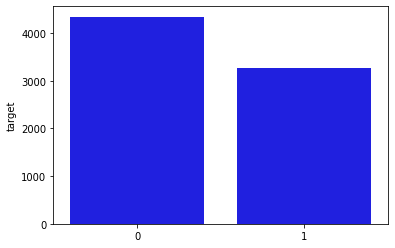

In [8]:
X=DF1_train["target"].value_counts()
print(X.dtypes)
X.index
mpl.bar(X.index,X)
sb.barplot(X.index,X,color="blue")

### If the Target were to remain imbalanced , then effort must be made to resample the data so as to have relatively attain better accuracy for a given model over the train data.


### 4. EDA(EXPLORATORY DATA ANALYSIS) 

### Indicates Character count in each sentence

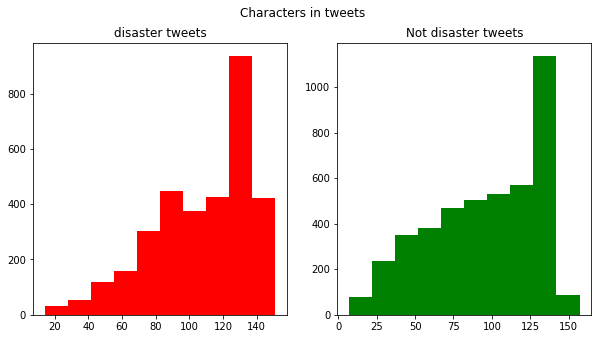

In [12]:
fig,(ax1,ax2)=mpl.subplots(1,2,figsize=(10,5))
tweet_len=DF1_train[DF1_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=DF1_train[DF1_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
mpl.show()

### Indicates Word count in each sentence

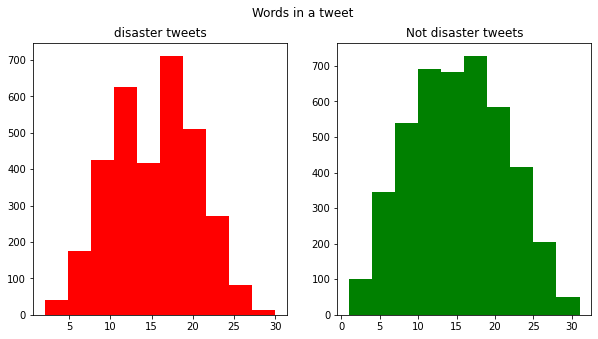

In [13]:
fig,(ax1,ax2)=mpl.subplots(1,2,figsize=(10,5))
tweet_len=DF1_train[DF1_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=DF1_train[DF1_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
mpl.show()

### APPLYING VECTORIZTION MODELS TO THE DATASET(BAG,TFIDF) 

### Improving the legibility of dataset by USING stemming/lemmatization & removal of stop words from the data & arriving at generating CORPUS

In [14]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#ps = PorterStemmer()

lemma=WordNetLemmatizer()
corpus = []
for i in range(0, len(DF1_train)):
    review = re.sub('[^a-zA-Z]', ' ', DF1_train['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    
    


## BOW MODEL

In [15]:
def BOW(corpus):
    # Creating the Bag of Words model
    from sklearn.feature_extraction.text import CountVectorizer
    cv = CountVectorizer(max_features=2500)
    X = cv.fit_transform(corpus).toarray()

    y=(DF1_train["target"])
    return X,y





## TFIDF MODEL

In [16]:
def Tfidf_model(corpus):# Creating the Bag of Words model
    from sklearn.feature_extraction.text import TfidfVectorizer
    cv = TfidfVectorizer(max_features=2500)
    X = cv.fit_transform(corpus).toarray()

    y=(DF1_train["target"])
    return X,y

# TRAINED BASED ON BOW

In [17]:
X,y=BOW(corpus)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

### MEtrics for calcualtion of accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
matrix=confusion_matrix(y_test,y_pred)
print("confuse_matrix=", matrix)
print()
score=accuracy_score(y_test,y_pred)
print('accur_score=',score)

report=classification_report(y_test,y_pred)
print("classify_report",report)


confuse_matrix= [[761 125]
 [182 455]]

accur_score= 0.7984241628365069
classify_report               precision    recall  f1-score   support

           0       0.81      0.86      0.83       886
           1       0.78      0.71      0.75       637

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



# TRAINED BASED ON TFIDF

In [18]:

X,y=Tfidf_model(corpus)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

### MEtrics for calcualtion of accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
matrix=confusion_matrix(y_test,y_pred)
print("confuse_matrix=", matrix)
print()
score=accuracy_score(y_test,y_pred)
print('accur_score=',score)

report=classification_report(y_test,y_pred)
# 
print("classify_report",report)



confuse_matrix= [[785 101]
 [211 426]]

accur_score= 0.7951411687458962
classify_report               precision    recall  f1-score   support

           0       0.79      0.89      0.83       886
           1       0.81      0.67      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

